<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center>Assignment #6
### <center> Beating baselines in "How good is your Medium article?"
    
<img src='../../img/medium_claps.jpg' width=40% />


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "A6 baseline" (~1.45 Public LB score). Do not forget about our shared ["primitive" baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline) - you'll find something valuable there.

**Your task:**
 1. "Freeride". Come up with good features to beat the baseline "A6 baseline" (for now, public LB is only considered)
 2. You need to name your [team](https://www.kaggle.com/c/how-good-is-your-medium-article/team) (out of 1 person) in full accordance with the [course rating](https://drive.google.com/open?id=19AGEhUQUol6_kNLKSzBsjcGUU3qWy3BNUg8x8IFkO3Q). You can think of it as a part of the assignment. 16 credits for beating the mentioned baseline and correct team naming.
 
*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a6__*

In [103]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
import re
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexander.brukhanov\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!


The following code will help to throw away all HTML tags from an article content.

In [5]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [6]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [137]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['image']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:
        
        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            #content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            #content_no_html_tags = strip_tags(content)
            #feature_files[0].write(content_no_html_tags + "\n")
            #published = json_data['published']['$date']
            #feature_files[1].write(published +"\n")
            image_ = json_data['image_url']
            feature_files[0].write(str(image_)+"\n")
            # You code here

In [138]:
PATH_TO_DATA = 'kaggle_medium' # modify this if you need to

In [139]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

In [140]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [25]:
X_train_content_sparse = pd.read_csv(PATH_TO_DATA+'/train_content.txt', sep="\n", header=None)

In [35]:
X_train_content_sparse=X_train_content_sparse.rename(columns={0: "content"})

In [36]:
X_train_content_sparse.head()

,content
0,"MediumEveryone’s stories and ideasAug 13, 2012..."
1,"MediumEveryone’s stories and ideasAug 2, 2015 ..."
2,"Yun-Chen Chien（簡韻真）Nobody in @g0v.tw, PM in se..."
3,Vaibhav KhulbeAndroid App Developer | I write ...
4,Vaibhav KhulbeAndroid App Developer | I write ...


In [48]:
X_test_content_sparse = pd.read_csv(PATH_TO_DATA+'/test_content.txt', sep="\n", header=None)

In [49]:
X_test_content_sparse=X_test_content_sparse.rename(columns={0: "content"})

In [28]:
def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 1. Remove non-letters
    sentence_text = re.sub(r'[^\w\s]','', sentence)
    # 2. Convert words to lower case and split them
    words = sentence_text.lower().split()
    # 3. Return a list of words
    return(words)

In [29]:
def oped_to_sentences(oped, tokenizer, remove_stopwords=False ):
    try:
        # 1. Use the NLTK tokenizer to split the text into sentences
        raw_sentences = tokenizer.tokenize(oped.strip())
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call sentence_to_wordlist to get a list of words
                sentences.append(sentence_to_wordlist(raw_sentence))
        # 3. Return the list of sentences (each sentence is a list of words, so this returns a list of lists)
        len(sentences)
        return sentences
    except:
        print('nope')

In [53]:
#content_list = pd.concat([X_train_content_sparse,X_test_content_sparse],axis = 0,ignore_index = True)['content'].tolist()

In [50]:
content_list = pd.concat(X_train_content_sparse, X_test_content_sparse)['content'].tolist()
sentences = []

for i in range(0,len(content_list)):
    try:
        # Need to first change "./." to "." so that sentences parse correctly
        oped = content_list[i].replace("/.", '')
        # Now apply functions
        sentences += oped_to_sentences(oped, tokenizer)
    except:
        print('no!')

In [39]:
import gensim
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.models import Phrases
import logging

C:\Users\alexander.brukhanov\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [40]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [41]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 50   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [51]:
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

2018-11-18 19:37:12,013 : INFO : collecting all words and their counts
2018-11-18 19:37:12,017 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-18 19:37:12,153 : INFO : PROGRESS: at sentence #10000, processed 277461 words, keeping 36705 word types
2018-11-18 19:37:12,201 : INFO : PROGRESS: at sentence #20000, processed 537635 words, keeping 61356 word types
2018-11-18 19:37:12,264 : INFO : PROGRESS: at sentence #30000, processed 808600 words, keeping 86367 word types
2018-11-18 19:37:12,468 : INFO : PROGRESS: at sentence #40000, processed 1072610 words, keeping 108188 word types
2018-11-18 19:37:12,545 : INFO : PROGRESS: at sentence #50000, processed 1364528 words, keeping 125926 word types
2018-11-18 19:37:12,596 : INFO : PROGRESS: at sentence #60000, processed 1639124 words, keeping 146161 word types
2018-11-18 19:37:12,634 : INFO : PROGRESS: at sentence #70000, processed 1828091 words, keeping 154665 word types
2018-11-18 19:37:12,691 : INFO : PROGR

2018-11-18 19:37:19,921 : INFO : PROGRESS: at sentence #1390000, processed 37621205 words, keeping 1564734 word types
2018-11-18 19:37:19,967 : INFO : PROGRESS: at sentence #1400000, processed 37890531 words, keeping 1572240 word types
2018-11-18 19:37:20,014 : INFO : PROGRESS: at sentence #1410000, processed 38152964 words, keeping 1580350 word types
2018-11-18 19:37:20,063 : INFO : PROGRESS: at sentence #1420000, processed 38408116 words, keeping 1588779 word types
2018-11-18 19:37:20,111 : INFO : PROGRESS: at sentence #1430000, processed 38673450 words, keeping 1595684 word types
2018-11-18 19:37:20,161 : INFO : PROGRESS: at sentence #1440000, processed 38936463 words, keeping 1605033 word types
2018-11-18 19:37:20,210 : INFO : PROGRESS: at sentence #1450000, processed 39203686 words, keeping 1612408 word types
2018-11-18 19:37:20,260 : INFO : PROGRESS: at sentence #1460000, processed 39462557 words, keeping 1625712 word types
2018-11-18 19:37:20,309 : INFO : PROGRESS: at sentence #

2018-11-18 19:37:26,750 : INFO : PROGRESS: at sentence #2770000, processed 74648872 words, keeping 2664586 word types
2018-11-18 19:37:26,802 : INFO : PROGRESS: at sentence #2780000, processed 74937389 words, keeping 2672401 word types
2018-11-18 19:37:26,850 : INFO : PROGRESS: at sentence #2790000, processed 75196085 words, keeping 2678742 word types
2018-11-18 19:37:26,900 : INFO : PROGRESS: at sentence #2800000, processed 75461966 words, keeping 2686681 word types
2018-11-18 19:37:26,948 : INFO : PROGRESS: at sentence #2810000, processed 75732601 words, keeping 2693191 word types
2018-11-18 19:37:26,998 : INFO : PROGRESS: at sentence #2820000, processed 76001138 words, keeping 2700068 word types
2018-11-18 19:37:27,043 : INFO : PROGRESS: at sentence #2830000, processed 76225628 words, keeping 2705968 word types
2018-11-18 19:37:27,095 : INFO : PROGRESS: at sentence #2840000, processed 76499684 words, keeping 2714152 word types
2018-11-18 19:37:27,151 : INFO : PROGRESS: at sentence #

2018-11-18 19:37:33,974 : INFO : PROGRESS: at sentence #4150000, processed 112089450 words, keeping 3683572 word types
2018-11-18 19:37:34,029 : INFO : PROGRESS: at sentence #4160000, processed 112361513 words, keeping 3689759 word types
2018-11-18 19:37:34,092 : INFO : PROGRESS: at sentence #4170000, processed 112660755 words, keeping 3697326 word types
2018-11-18 19:37:34,149 : INFO : PROGRESS: at sentence #4180000, processed 112929075 words, keeping 3702165 word types
2018-11-18 19:37:34,206 : INFO : PROGRESS: at sentence #4190000, processed 113207009 words, keeping 3709796 word types
2018-11-18 19:37:34,261 : INFO : PROGRESS: at sentence #4200000, processed 113481582 words, keeping 3717773 word types
2018-11-18 19:37:34,320 : INFO : PROGRESS: at sentence #4210000, processed 113786893 words, keeping 3725785 word types
2018-11-18 19:37:34,375 : INFO : PROGRESS: at sentence #4220000, processed 114077964 words, keeping 3732043 word types
2018-11-18 19:37:34,433 : INFO : PROGRESS: at se

2018-11-18 19:37:41,626 : INFO : PROGRESS: at sentence #5510000, processed 150027264 words, keeping 4675177 word types
2018-11-18 19:37:41,684 : INFO : PROGRESS: at sentence #5520000, processed 150324707 words, keeping 4681514 word types
2018-11-18 19:37:41,740 : INFO : PROGRESS: at sentence #5530000, processed 150610475 words, keeping 4689942 word types
2018-11-18 19:37:41,796 : INFO : PROGRESS: at sentence #5540000, processed 150902149 words, keeping 4696860 word types
2018-11-18 19:37:41,853 : INFO : PROGRESS: at sentence #5550000, processed 151183918 words, keeping 4705025 word types
2018-11-18 19:37:41,906 : INFO : PROGRESS: at sentence #5560000, processed 151461165 words, keeping 4711414 word types
2018-11-18 19:37:41,960 : INFO : PROGRESS: at sentence #5570000, processed 151728741 words, keeping 4718223 word types
2018-11-18 19:37:42,015 : INFO : PROGRESS: at sentence #5580000, processed 151992893 words, keeping 4728625 word types
2018-11-18 19:37:42,051 : INFO : collected 47320

2018-11-18 19:39:48,068 : INFO : EPOCH 2 - PROGRESS: at 34.32% examples, 1254818 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:49,068 : INFO : EPOCH 2 - PROGRESS: at 35.51% examples, 1256744 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:50,072 : INFO : EPOCH 2 - PROGRESS: at 36.64% examples, 1257362 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:51,076 : INFO : EPOCH 2 - PROGRESS: at 37.79% examples, 1258916 words/s, in_qsize 7, out_qsize 1
2018-11-18 19:39:52,076 : INFO : EPOCH 2 - PROGRESS: at 38.93% examples, 1259772 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:53,084 : INFO : EPOCH 2 - PROGRESS: at 40.09% examples, 1260927 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:54,085 : INFO : EPOCH 2 - PROGRESS: at 41.20% examples, 1262209 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:55,087 : INFO : EPOCH 2 - PROGRESS: at 42.32% examples, 1263730 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:39:56,090 : INFO : EPOCH 2 - PROGRESS: at 43.45% examples, 1264598 words/s

2018-11-18 19:42:07,248 : INFO : EPOCH 3 - PROGRESS: at 85.50% examples, 1233262 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:08,253 : INFO : EPOCH 3 - PROGRESS: at 86.56% examples, 1233540 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:09,256 : INFO : EPOCH 3 - PROGRESS: at 87.63% examples, 1234069 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:10,263 : INFO : EPOCH 3 - PROGRESS: at 88.70% examples, 1234072 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:11,273 : INFO : EPOCH 3 - PROGRESS: at 89.76% examples, 1234198 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:12,273 : INFO : EPOCH 3 - PROGRESS: at 90.76% examples, 1233735 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:13,275 : INFO : EPOCH 3 - PROGRESS: at 91.65% examples, 1231716 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:14,276 : INFO : EPOCH 3 - PROGRESS: at 92.67% examples, 1230938 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:42:15,284 : INFO : EPOCH 3 - PROGRESS: at 93.78% examples, 1231281 words/s

2018-11-18 19:44:23,411 : INFO : EPOCH 5 - PROGRESS: at 32.00% examples, 1252417 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:24,411 : INFO : EPOCH 5 - PROGRESS: at 33.23% examples, 1253244 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:25,415 : INFO : EPOCH 5 - PROGRESS: at 34.34% examples, 1254269 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:26,419 : INFO : EPOCH 5 - PROGRESS: at 35.50% examples, 1255109 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:27,423 : INFO : EPOCH 5 - PROGRESS: at 36.63% examples, 1255789 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:28,423 : INFO : EPOCH 5 - PROGRESS: at 37.75% examples, 1256607 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:29,426 : INFO : EPOCH 5 - PROGRESS: at 38.90% examples, 1257686 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:30,426 : INFO : EPOCH 5 - PROGRESS: at 40.06% examples, 1259148 words/s, in_qsize 7, out_qsize 0
2018-11-18 19:44:31,430 : INFO : EPOCH 5 - PROGRESS: at 41.16% examples, 1260201 words/s

In [54]:
model_name = "medium_w2v_model"
model.save(model_name)
#new_model = gensim.models.Word2Vec.load('medium_w2v_model')

2018-11-18 19:47:04,866 : INFO : saving Word2Vec object under medium_w2v_model, separately None
2018-11-18 19:47:04,868 : INFO : storing np array 'vectors' to medium_w2v_model.wv.vectors.npy
2018-11-18 19:47:05,110 : INFO : not storing attribute vectors_norm
2018-11-18 19:47:05,112 : INFO : storing np array 'syn1neg' to medium_w2v_model.trainables.syn1neg.npy
2018-11-18 19:47:05,347 : INFO : not storing attribute cum_table
2018-11-18 19:47:05,518 : INFO : saved medium_w2v_model


In [55]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

C:\Users\alexander.brukhanov\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [56]:
def fingerprint(text, model, weights=False):
    """
    :param text: list of words
    :param model: word2vec model in Gensim format
    :param weights: whether to use word weights based on frequencies (word2vec model should contain frequency data)
    :return: average vector of words in text
    """
    # Creating list of all words in the document, which are present in the model
    words = [w for w in text if w in model]
    lexicon = list(set(words))
    lw = len(lexicon)
    if lw < 1:
        print('Empty lexicon in', text)
        return np.zeros(model.vector_size)
    vectors = np.zeros((lw, model.vector_size))  # Creating empty matrix of vectors for words
    for i in list(range(lw)):  # Iterate over words in the text
        word = lexicon[i]
        if weights:
            weight = wordweight(word, model)
        else:
            weight = 1.0
        vectors[i, :] = model[word] * weight  # Adding word and its vector to matrix
    semantic_fingerprint = np.sum(vectors, axis=0)  # Computing sum of all vectors in the document
    semantic_fingerprint = np.divide(semantic_fingerprint, lw)  # Computing average vector
    return semantic_fingerprint


def wordweight(word, model, a=10 ** -3, wcount=250000000):
    """
    :param word: word token
    :param model: word2vec model in Gensim format
    :param a: smoothing coefficient
    :param wcount: number of words in the training corpus (the default value corresponds to the RNC)
    :return: word weight (rare words get higher weights)
    """
    prob = model.wv.vocab[word].count / wcount
    weight = a / (a + prob)
    return weight

In [81]:
model.vector_size


300

In [91]:
matrix = np.empty((X_train_content_sparse.shape[0], model.vector_size))
content_list = X_train_content_sparse['content'].tolist()

for i in range(0,len(X_train_content_sparse)):
    try:
        # Need to first change "./." to "." so that sentences parse correctly
        oped = content_list[i].replace("/.", '')
        # Now apply functions
        sentence = sentence_to_wordlist(oped, tokenizer)
        #print(sentence)
        #bow = [b for b in sentence]
        #print(bow)
        fp = fingerprint(sentence, model, 0)
        #if "error" not in q:
        #    bow = q.split()
        #    bow = [b for b in bow]
        #    fp = fingerprint(bow, model, 0)
        #else:
        #    print('Error at ', q)
        matrix[i, :] = fp
    except:
        print('no!')
       

C:\Users\alexander.brukhanov\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
C:\Users\alexander.brukhanov\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [92]:
matrix.shape

(62313, 300)

In [108]:
matrix_test = np.empty((X_test_content_sparse.shape[0], model.vector_size))
content_list = X_test_content_sparse['content'].tolist()

for i in range(0,len(X_test_content_sparse)):
    try:
        # Need to first change "./." to "." so that sentences parse correctly
        oped = content_list[i].replace("/.", '')
        # Now apply functions
        sentence = sentence_to_wordlist(oped, tokenizer)
        #print(sentence)
        #bow = [b for b in sentence]
        #print(bow)
        fp = fingerprint(sentence, model, 0)
        #if "error" not in q:
        #    bow = q.split()
        #    bow = [b for b in bow]
        #    fp = fingerprint(bow, model, 0)
        #else:
        #    print('Error at ', q)
        matrix_test[i, :] = fp
    except:
        print('no!')

C:\Users\alexander.brukhanov\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
C:\Users\alexander.brukhanov\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [152]:
X_train_image_sparse = pd.read_csv(PATH_TO_DATA+'/train_image.txt', sep="\n", header=None)

In [157]:
X_test_image_sparse = pd.read_csv(PATH_TO_DATA+'/test_image.txt', sep="\n", header=None)

In [158]:
X_test_image_sparse=X_test_image_sparse.rename(columns={0: "image"})

In [159]:
X_test_image_sparse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34645 entries, 0 to 34644
Data columns (total 1 columns):
image    34645 non-null object
dtypes: object(1)
memory usage: 270.7+ KB


In [155]:
X_train_image_sparse['image'] = X_train_image_sparse['image'].apply(lambda x: 0 if x == 'None' else 1)

In [156]:
X_train_image_sparse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62313 entries, 0 to 62312
Data columns (total 1 columns):
image    62313 non-null int64
dtypes: int64(1)
memory usage: 486.9 KB


In [160]:
X_test_image_sparse['image'] = X_test_image_sparse['image'].apply(lambda x: 0 if x == 'None' else 1)

**Join all sparse matrices.**

In [184]:
X_train_content_sparse = matrix
X_train_sparse = hstack([X_train_content_sparse, X_train_image_sparse])

In [185]:
X_test_content_sparse = matrix_test
X_test_sparse = hstack([X_test_content_sparse, X_test_image_sparse])


In [189]:
type(X_train_sparse)

scipy.sparse.coo.coo_matrix

**Read train target and split data for validation.**

In [190]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [191]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

TypeError: 'coo_matrix' object is not subscriptable

**Train a simple Ridge model and check MAE on the validation set.**

In [170]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=17)


In [171]:
%%time
ridge.fit(X_train_part_sparse, y_train_part);

Wall time: 4.68 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [172]:
ridge_pred = ridge.predict(X_valid_sparse)

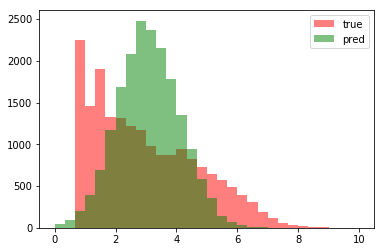

In [173]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [175]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.2816719069073894, 2.602658001966898)

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [107]:
%%time
ridge.fit(X_train_sparse, y_train);

Wall time: 285 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [110]:
%%time
ridge_test_pred = ridge.predict(X_test_sparse)

Wall time: 21.9 ms


In [111]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [112]:
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA,
                                                    'assignment6_medium_submission.csv'))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeros. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [ ]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [ ]:
ridge_test_pred_modif = ridge_test_pred # You code here

In [ ]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment6_medium_submission_with_hack.csv'))

In [121]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

In [127]:
# Опишем нашу сеть.
def baseline_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_part_sparse.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=baseline_model,epochs=20, nb_epoch=20, batch_size=64,validation_data=(X_valid_sparse, y_valid), verbose=2)


In [128]:
estimator.fit(X_train_part_sparse, y_train_part)

Train on 43619 samples, validate on 18694 samples
Epoch 1/10


InternalError: GPU sync failed

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>